# Lab 10: Pharmacogenomic Analysis - Drug Sensitivity in Breast Cancer

## Overview  
This analysis explores the inhibitory efficiency (IC50) of a drug in breast cancer using the **Genomics of Drug Sensitivity in Cancer (GDSC)** dataset. We compare various experiments by analyzing key biological and experimental features that influence drug response.

**Recall** that the IC50 represents the drug concentration needed to inhibit 50% of cell viability in cell line experiments.
<img src="dose-response-curve.png" alt="drawing" style="width:500px;"/>

## Topics Covered

### 1. Data Processing / Exploration
In this step, we will load the GDSC dataset and perform initial data processing and exploration. This includes:
- Loading the dataset and displaying summary statistics.
- Visualizing the distribution of key variables, such as the IC50 values, to understand the data better.

### 2. Framing the Question / Formatting the Data for ML
In this step, we will frame the machine learning question we want to answer. This includes:
- Defining the target variable (e.g., binary classification of drug sensitivity based on IC50 values) and the features (e.g., gene expression levels, mutation status).
- Splitting the data into training and testing sets to evaluate the performance of our models.

### 3. Implementing ML Models
In this step, we will implement and evaluate various machine learning models to predict drug sensitivity. This includes:
- Building a simple baseline model, such as logistic regression, to establish a performance benchmark.
- Implementing more advanced models, such as decision trees, random forests, or support vector machines, to improve prediction accuracy.
- Evaluating the performance of the models using appropriate metrics, such as or accuracy, F1-score, etc.
- Visualizing the results to interpret the model's performance and understand the key features influencing drug sensitivity.


## 1. Data Processing / Exploration

We will start by loading a semi-curated dataset, where the raw data is available from the Genomics of Drug Sensitivity in Cancer (GDSC) database (https://www.cancerrxgene.org/).

In [14]:
# Package imports - loading and plotting stuff
import pandas as pd, numpy as np, random
import matplotlib.pyplot as plt, seaborn as sns

# Load / quick formatting
raw_data = pd.read_csv("GDSC_DATASET.csv")  
raw_data.columns = [" ".join(x.split("\n")).lower() for x in raw_data.columns]

#print the number of rows and columns
print(f"Number of rows: {raw_data.shape[0]}, Number of columns: {raw_data.shape[1]}")

#In col  Cancer type find the unique values and their counts
cancer_type_counts = raw_data.iloc[:, [10]].value_counts()
# Print the top 3 cancer types
top_3_cancer_types = cancer_type_counts.head(3)
print("Top 3 cancer types and their counts:")
print(top_3_cancer_types)   

Number of rows: 242035, Number of columns: 19
Top 3 cancer types and their counts:
cancer type (matching tcga label)
LUAD                                 15483
SCLC                                 13750
BRCA                                 13106
Name: count, dtype: int64


**Columns of GDSC dataset:**
1. **COSMIC_ID:** Unique identifier for the cell line from the COSMIC database.
2. **CELL_LINE_NAME:** Name of the cancer cell line used in the experiment.
3. **TCGA_DESC:** Description of the cancer type according to The Cancer Genome Atlas.
4. **DRUG_ID:** Unique identifier for the drug used in the experiment.
5. **DRUG_NAME:** Name of the drug used in the experiment.
6. **LN_IC50:** Natural log of the half-maximal inhibitory concentration (IC50).
7. **AUC:** Area Under the Curve, a measure of drug effectiveness.
9. **Z_SCORE:** Standardized score of the drug response, allowing comparison across different drugs and cell lines.
9. **GDSC Tissue descriptor 1:** Primary tissue type classification.
10. **GDSC Tissue descriptor 2:** Secondary tissue type classification.
11. **Cancer Type (matching TCGA label):** Cancer type according to TCGA classification.
12. **Microsatellite instability Status (MSI):** Indicates the cell line's MSI status.
13. **Screen Medium:** The growth medium used for culturing the cell line.
14. **Growth Properties:** Characteristics of how the cell line grows in culture.
15. **Copy Number Alterations (CNA):** Data on gene copy number changes in the cell line.
16. **Gene Expression:** Information on gene expression levels in the cell line.
17. **Methylation:** Data on DNA methylation patterns in the cell line.
18. **TARGET:** The molecular target(s) of the drug.
19. **TARGET_PATHWAY:** The biological pathway(s) targeted by the drug.

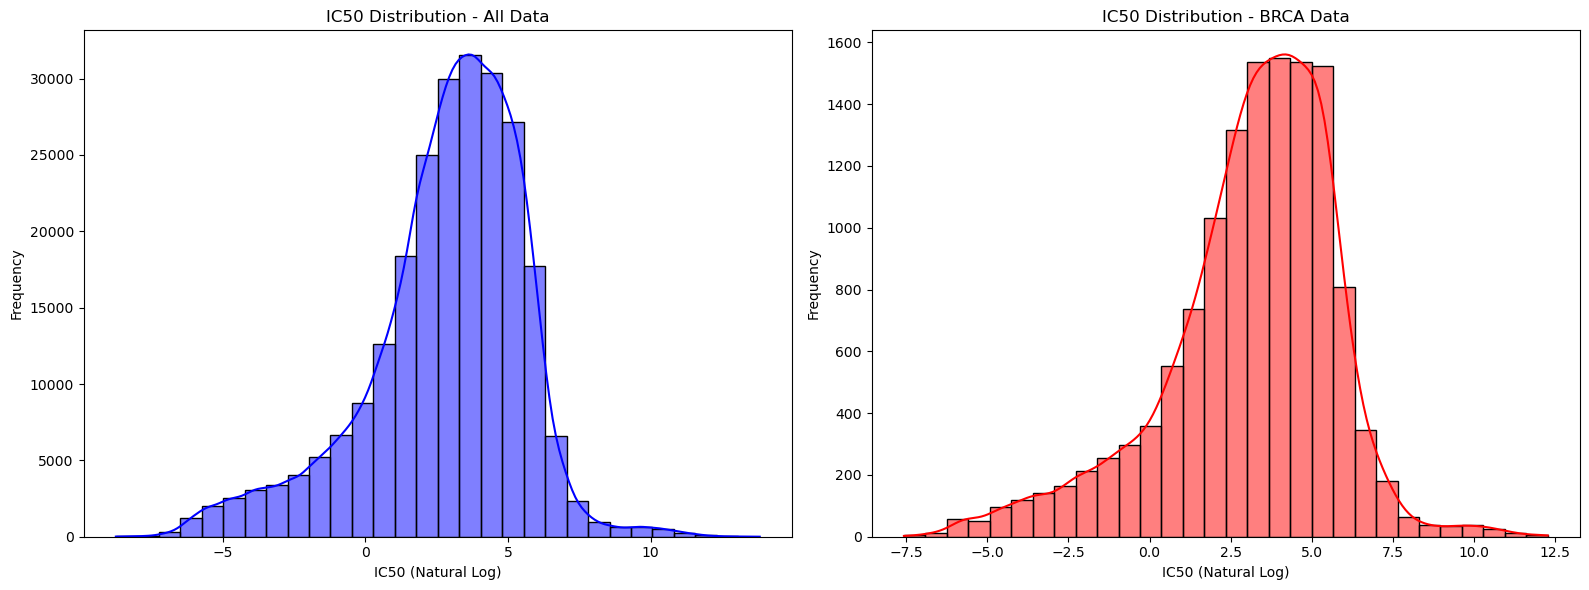

Correlations with ln_ic50:
ln_ic50    1.000000
auc        0.740435
z_score    0.491849
Name: ln_ic50, dtype: float64


In [15]:
# Isolate the breast cancer data
brca_data = raw_data.copy()[raw_data["tcga_desc"] == "BRCA"]

# Visualize the IC50 Distribution for all data and our subset of interest
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(raw_data["ln_ic50"], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title('IC50 Distribution - All Data')
axes[0].set_xlabel("IC50 (Natural Log)")
axes[0].set_ylabel("Frequency")

sns.histplot(brca_data["ln_ic50"], bins=30, kde=True, color='red', ax=axes[1])
axes[1].set_title('IC50 Distribution - BRCA Data')
axes[1].set_xlabel("IC50 (Natural Log)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


# Select numerical columns and the target
numerical_cols = ["ln_ic50", "auc", "z_score"]
numerical_data = brca_data[numerical_cols]

# Compute correlations with the target variable (ln_ic50)
correlations = numerical_data.corr()["ln_ic50"].sort_values(ascending=False)
print("Correlations with ln_ic50:")
print(correlations)

## Questions for Exploration

1. How many experiments are in this dataset (i.e., number of rows)?  242035
2. How many different cancer types are represented? Which are the top 3 in terms of number of experiments available?LUAD                                 15483
SCLC                                 13750
BRCA                                 13106
3. What are the correlations between numerical features and the target variable (IC50)? Is this expected? Yes the correlations are as expected becucase ic50 and auc measure drug response and , higher correlation means that there is a simillarity in the drug response. The zscores are related inversly therfor a lower zscore is inidicative of drug sensitivity
4. What is the distribution of IC50 values across different categories (e.g., MSI status, screen medium)?

## 2. Framing the Question / Formatting the Data for ML
In this step, we will frame the machine learning question we want to answer. 

### Pairwise Comparison Approach  
- Each experiment is represented as a feature vector $X_a$ and $X_b$.  
- We compare the IC50 values ($y_a$, $y_b$) between two experiments to determine which experimental condition leads to higher or lower drug sensitivity.  
- This transforms the problem into a binary classification task, where the model predicts whether one condition results in an increase or decrease in IC50. 

### Features Considered  
- **Binary Features:**  
  - Microsatellite instability (MSI) status  
  - Screen medium  
  - Copy number alterations (CNA)  
  - Gene expression  
  - Methylation  

- **Ternary Feature:**  
  - Growth properties of cancer cells (adherent, semi-adherent, suspension)  

- **Drug Target Pathway:**  
  - Captures the molecular mechanism of action of the drug   

In [16]:
# Isolate the data of interest
cols_to_keep = ["microsatellite instability status (msi)", "screen medium", "cna", "gene expression", "methylation", "growth properties", "target_pathway"]              
y = brca_data.copy()["ln_ic50"]
X = brca_data.copy()[cols_to_keep] 

# Encode categorical features
X["microsatellite instability status (msi)"] = X["microsatellite instability status (msi)"].map({"MSS/MSI-L": 1, "MSI-H": 0})
X["growth properties"] = X["growth properties"].map({"Adherent": 0, "Semi-adherent": 1, "Suspension": 2})
X["screen medium"] = X["screen medium"].map({"D/F12": 0, "R": 1})
X["cna"] = X["cna"].map({"Y": 1, "N": 0})
X["gene expression"] = X["gene expression"].map({"Y": 1, "N": 0})
X["methylation"] = X["methylation"].map({"Y": 1, "N": 0})

# Encode drug target pathway
X = pd.get_dummies(X, columns=["target_pathway"])
# X.head()

In [17]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Generate pairwise indices for training and testing sets
def generate_pairwise_indices(X, y, n_pairs=80_000):
    idx = np.array([(a, b) for a, b in zip(random.choices(X.index, k=n_pairs), random.choices(X.index, k=n_pairs)) if a != b])
    X_diff = X.loc[idx[:, 0]].to_numpy() - X.loc[idx[:, 1]].to_numpy()
    y_diff = y.loc[idx[:, 0]].to_numpy() - y.loc[idx[:, 1]].to_numpy()
    y_diff = y_diff > 0
    return X_diff, y_diff

# Generate pairwise training data
X_train_diff, y_train_diff = generate_pairwise_indices(X_train, y_train)

# Generate pairwise testing data
X_test_diff, y_test_diff = generate_pairwise_indices(X_test, y_test, n_pairs=20_000)

# Display the shapes of the generated datasets
print("X_train_diff shape:", X_train_diff.shape)
print("y_train_diff shape:", y_train_diff.shape)
print("X_test_diff shape:", X_test_diff.shape)
print("y_test_diff shape:", y_test_diff.shape)

X_train_diff shape: (79989, 30)
y_train_diff shape: (79989,)
X_test_diff shape: (19990, 30)
y_test_diff shape: (19990,)


## 3. Implementing ML Models
In this step, we will implement and evaluate various machine learning models to predict drug sensitivity. 

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Use logistic regression as a baseline model
base_model = LogisticRegression(max_iter=1000, random_state=42)
base_model.fit(X_train_diff, y_train_diff)
# Evaluate the baseline model
base_accuracy = base_model.score(X_test_diff, y_test_diff)  
print(f"Baseline Logistic Regression Accuracy: {base_accuracy:.4f}")

# INSERT CODE HERE




# Try something a little fancier (vroom vroom)
# INSERT CODE HERE



# Pretty plots and evaluation metrics!
# INSERT CODE HERE

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## Questions for Exploration

1. How do the logistic regression and random forest models compare in terms of accuracy?
2. Which features are the most important in predicting drug sensitivity (IC50)?
3. Are there any features that consistently appear as important across different models? 
4. Are there any surprising or counterintuitive findings in the feature importances? (i.e., would this support or refute any related biological hypothesis?)
5. How robust are the models to changes in the training data? For example, how does the performance change if we use a different random seed for the train-test split?
6. How do the models perform on different subsets of the data (e.g., different cancer subtypes)?
7. What are the optimal hyperparameters for the logistic regression and random forest models?
8. How does the performance change with different hyperparameter settings?